## Project 1B

In [584]:
# Initial imports
import os
import requests
from pathlib import Path
import json
import numpy as np
import datetime as dt
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [585]:
# Load .env enviroment variables
load_dotenv()

True

In [586]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    base_url="https://paper-api.alpaca.markets",
    api_version="v2")

In [587]:
# Format current date as ISO format
today = pd.Timestamp("2021-03-31", tz="America/New_York").isoformat()
start_day = pd.Timestamp("2016-03-31", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["SCHZ", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SCHZ and SPY
ticker_data = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_day,
    end = today,
    limit = 1000
).df

# Preview DataFrame
ticker_data.head()

SCHZ                                        SPY  \
                            open     high      low  close    volume    open   
time                                                                          
2017-04-10 00:00:00-04:00  51.80  51.8400  51.7600  51.81  459968.0     NaN   
2017-04-11 00:00:00-04:00  51.90  51.9653  51.8470  51.94  407094.0  234.87   
2017-04-12 00:00:00-04:00  52.00  52.0800  51.9500  52.05  443459.0  234.74   
2017-04-13 00:00:00-04:00  52.14  52.1400  52.0267  52.11  557840.0  233.63   
2017-04-17 00:00:00-04:00  52.19  52.2000  52.0801  52.11  443970.0  233.11   

                                                               
                             high     low   close      volume  
time                                                           
2017-04-10 00:00:00-04:00     NaN     NaN     NaN         NaN  
2017-04-11 00:00:00-04:00  235.18  233.34  235.04  63951745.0  
2017-04-12 00:00:00-04:00  234.96  233.77  234.10  55338215.0  
2017-04-13 00:00:00-04:00  234.49  232.54  232.54  63216959.0  
2017-04-17 00:00:00-04:00  234.57  232.88  234.57  46820072.0

In [588]:
#Create SCHZ and SPY Dataframe
df_closingprice = pd.DataFrame()
df_closingprice["SCHZ"]= ticker_data["SCHZ"]["close"]
df_closingprice["SPY"]= ticker_data["SPY"]["close"]
df_closingprice.index=df_closingprice.index.date
df_closingprice.head()

,SCHZ,SPY
2017-04-10,51.81,NaN
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57


In [589]:
#Data Cleaning
df_closingprice.isnull().sum()

SCHZ    1
SPY     1
dtype: int64

In [590]:
df_closingprice = df_closingprice.dropna().copy()

In [591]:
df_closingprice.isnull().sum()

SCHZ    0
SPY     0
dtype: int64

In [592]:
df_closingprice.count()

SCHZ    999
SPY     999
dtype: int64

In [593]:
df_closingprice.head()

,SCHZ,SPY
2017-04-11,51.94,235.04
2017-04-12,52.05,234.10
2017-04-13,52.11,232.54
2017-04-17,52.11,234.57
2017-04-18,52.29,233.86


In [594]:
#Assigning weights to Traditional Income (ti) portfolio
ti_schz_percent = 0.80
ti_spy_percent = 0.20

traditional_returns = df_closingprice.pct_change()
traditional_returns = traditional_returns.dropna().copy()
weights_ti = [ti_schz_percent, ti_spy_percent]
ti_weighted = traditional_returns.dot(weights_ti)
ti_weighted.head()

2017-04-12    0.000894
2017-04-13   -0.000411
2017-04-17    0.001746
2017-04-18    0.002158
2017-04-19   -0.001404
dtype: float64

<AxesSubplot:title={'center':'Income Portfolio Cumulative Returns'}>

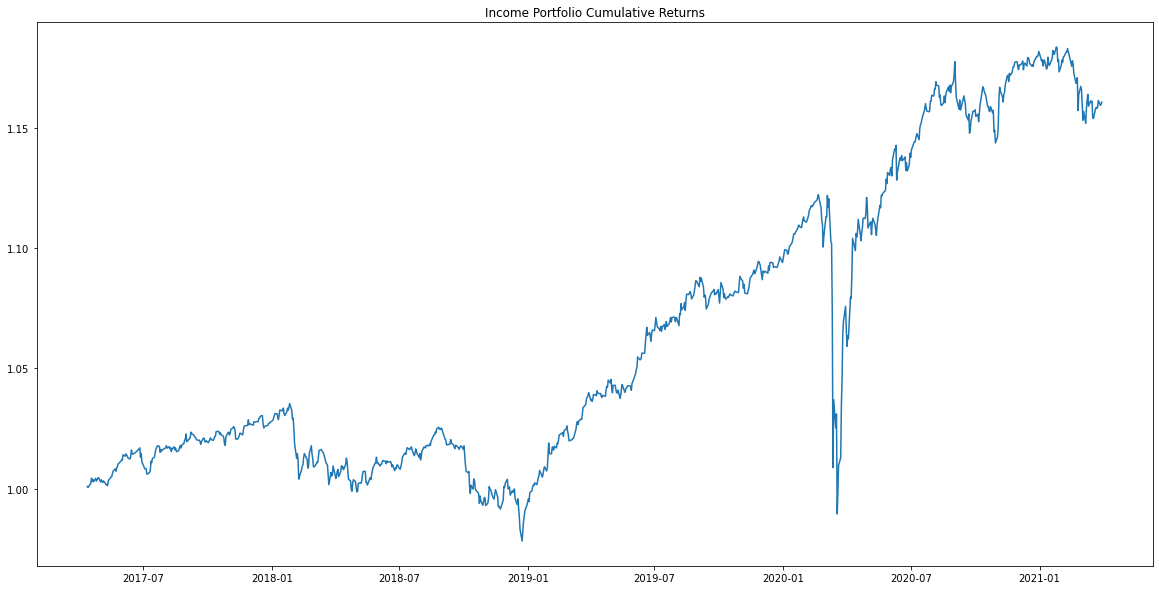

In [595]:
#Calculate and plot combined returns
ti_cumulative_returns = (1 + ti_weighted).cumprod()
ti_cumulative_returns.plot(figsize=(20,10), title = "Income Portfolio Cumulative Returns")

In [596]:
#Retrieve Crypto (BTC) Prices and create Dataframe
btc_prices_csv = Path("resources/btc_usd_5_year_historical.csv")
btc_prices = pd.read_csv(
    btc_prices_csv, index_col="Date", infer_datetime_format=True, parse_dates=True)
btc_prices = btc_prices.sort_index()
btc_prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-03,421.173004,421.579987,419.696991,420.903992,420.903992,38053700.0
2016-04-04,421.299011,422.342987,419.601013,421.444000,421.444000,50634300.0
2016-04-05,421.016998,424.256989,420.614014,424.029999,424.029999,60718000.0
2016-04-06,424.283997,424.527008,422.729004,423.412994,423.412994,59091000.0
2016-04-07,423.619995,423.657013,420.518005,422.744995,422.744995,57858600.0


In [597]:
#Isolate Crypto close price
btc_closingprice = pd.DataFrame()
btc_closingprice = btc_prices["Close"]
btc_closingprice.index= btc_closingprice.index.date
btc_closingprice.head()

2016-04-03    420.903992
2016-04-04    421.444000
2016-04-05    424.029999
2016-04-06    423.412994
2016-04-07    422.744995
Name: Close, dtype: float64

In [598]:
#Combine Traditional Income portfolio with Crypto to create Hybrid Portfolio
hybrid_close = pd.concat([df_closingprice, btc_closingprice], axis="columns", join="inner")
hybrid_close = hybrid_close.rename(columns={"Close": "Crypto"})
hybrid_close.head()

,SCHZ,SPY,Crypto
2017-04-11,51.94,235.04,1205.010010
2017-04-12,52.05,234.10,1200.369995
2017-04-13,52.11,232.54,1169.280029
2017-04-17,52.11,234.57,1193.910034
2017-04-18,52.29,233.86,1211.670044


In [599]:
#Calculating daily returns on Hybrid Portfolio
hybrid_returns = hybrid_close.pct_change()
hybrid_returns = hybrid_returns.dropna().copy()
hybrid_returns.head()

,SCHZ,SPY,Crypto
2017-04-12,0.002118,-0.003999,-0.003851
2017-04-13,0.001153,-0.006664,-0.025900
2017-04-17,0.000000,0.008730,0.021064
2017-04-18,0.003454,-0.003027,0.014876
2017-04-19,-0.001339,-0.001668,-0.001139


In [600]:
# Adding 2% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hi_btc_percent = 0.02
hi_schz_percent = ti_schz_percent - (ti_schz_percent * hi_btc_percent)
hi_spy_percent = ti_spy_percent - (ti_spy_percent * hi_btc_percent)

#Assigning weights to Hybrid Income (hi) Portfolio
weights_hi = [hi_schz_percent, hi_spy_percent, hi_btc_percent]
hi_portfolio_weighted = hybrid_returns.dot(weights_hi)
hi_portfolio_weighted.head()

2017-04-12    0.000799
2017-04-13   -0.000920
2017-04-17    0.002132
2017-04-18    0.002412
2017-04-19   -0.001399
dtype: float64

In [601]:
print(hi_schz_percent)
print(hi_spy_percent)
print(hi_btc_percent)

0.784
0.196
0.02


<AxesSubplot:title={'center':'Hybrid Income Portfolio Cumulative Returns'}>

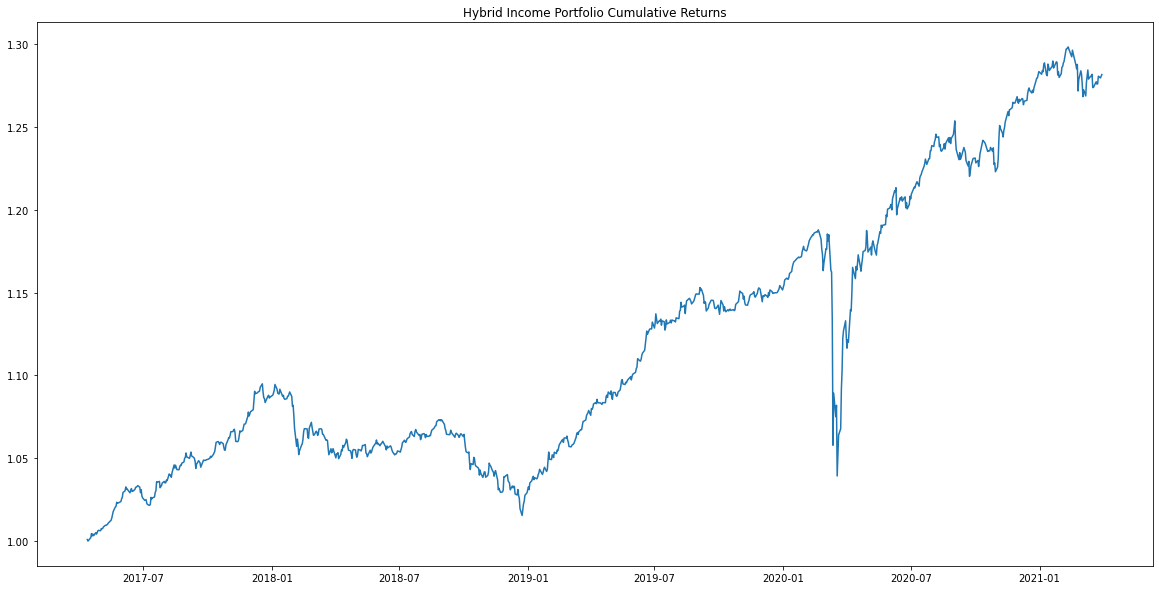

In [602]:
#Calculate and plot Hybrid Income Portfolio returns
hi_cumulative_hybrid_returns = (1 + hi_portfolio_weighted).cumprod()
hi_cumulative_hybrid_returns.plot(figsize=(20,10), title = "Hybrid Income Portfolio Cumulative Returns")

In [603]:
#Combined Traditional Income and Hybrid Income dataframes
thi_cumulative_returns = pd.concat([ti_portfolio_cumulative_returns, hi_cumulative_hybrid_returns], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_cumulative_returns.columns = columns
thi_cumulative_returns.tail()

,Traditional Income,Hybrid Income
2021-03-25,1.158720,1.276071
2021-03-26,1.161474,1.280719
2021-03-29,1.159624,1.279673
2021-03-30,1.159682,1.280767
2021-03-31,1.160787,1.281708


<AxesSubplot:title={'center':'Traditional vs. Hybrid Income Portfolio Cumulative Returns'}>

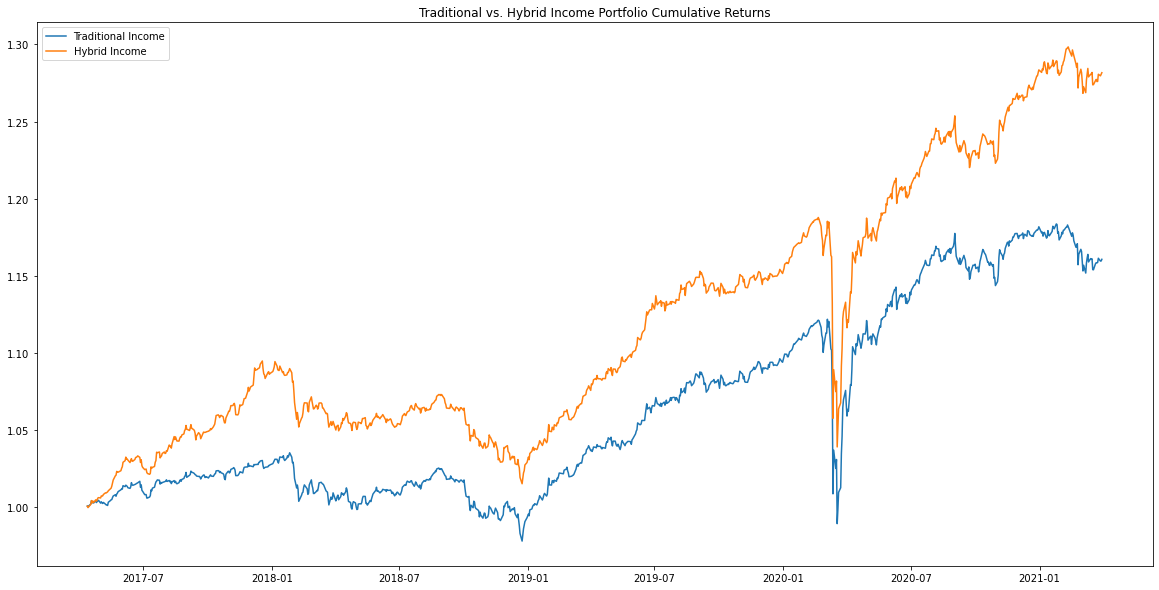

In [604]:
#Plot combined Income Dataframes
thi_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Income Portfolio Cumulative Returns")

In [605]:
#Combine Traditional and Hybrid Income Dataframes
thi_returns = pd.concat([ti_portfolio_weighted, hi_portfolio_weighted], axis="columns", join="inner")
columns = ["Traditional Income", "Hybrid Income"]
thi_returns.columns = columns
thi_returns.head()

,Traditional Income,Hybrid Income
2017-04-12,0.000894,0.000799
2017-04-13,-0.000411,-0.000920
2017-04-17,0.001746,0.002132
2017-04-18,0.002158,0.002412
2017-04-19,-0.001404,-0.001399


In [606]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
income_sharpe_ratios = (thi_returns.mean() * 252) / (thi_returns.std() * np.sqrt(252))
income_sharpe_ratios

Traditional Income    0.665802
Hybrid Income         1.009818
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

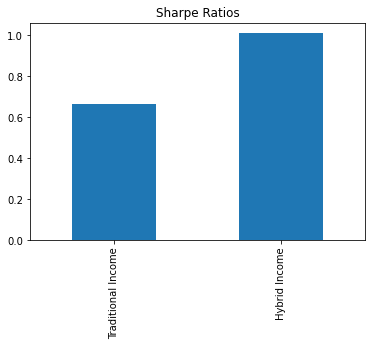

In [607]:
# Visualize the sharpe ratios as a bar plot
income_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Need to add summary statements

## 

### Start of Balanced Portfolio Section

In [608]:
#Assigning weights to Traditional Balanced (tb) portfolio
tb_schz_percent = 0.5
tb_spy_percent = 0.5
weights_tb = [tb_schz_percent, tb_spy_percent]
tb_weighted = traditional_returns.dot(weights_tb)
tb_weighted.head()

2017-04-12   -0.000941
2017-04-13   -0.002756
2017-04-17    0.004365
2017-04-18    0.000214
2017-04-19   -0.001503
dtype: float64

<AxesSubplot:title={'center':'Traditional Balanced Portfolio Cumulative Returns'}>

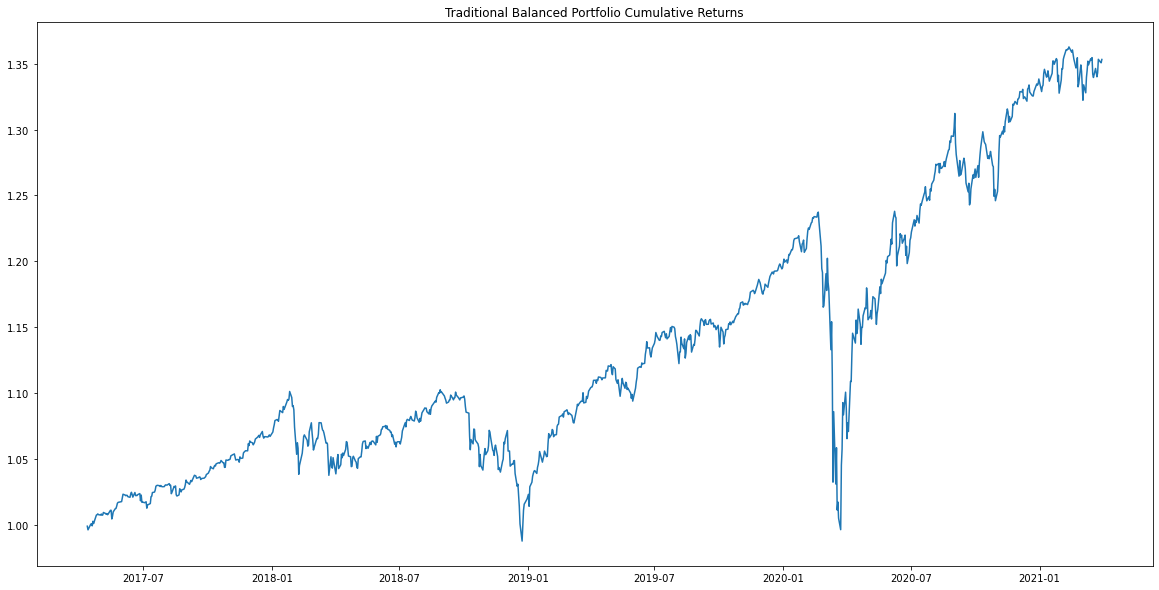

In [609]:
#Calculate and plot Traditional Balanced Portfolio returns
tb_cumulative_returns = (1 + balanced_portfolio_weighted).cumprod()
tb_cumulative_returns.plot(figsize=(20,10), title = "Traditional Balanced Portfolio Cumulative Returns")

In [610]:
# Adding 4% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hb_btc_percent = 0.04
hb_schz_percent = hi_schz_percent - (hi_schz_percent * hb_btc_percent)
hb_spy_percent = hi_spy_percent - (hi_spy_percent * hb_btc_percent)
weights_hb = [hb_schz_percent, hb_spy_percent, hb_btc_percent]
hb_weighted = hybrid_returns.dot(weights_hb)
hb_weighted.head()

2017-04-12    0.000687
2017-04-13   -0.001422
2017-04-17    0.002485
2017-04-18    0.002625
2017-04-19   -0.001367
dtype: float64

<AxesSubplot:title={'center':'Hybrid Balanced Cumulative Portfolio Returns'}>

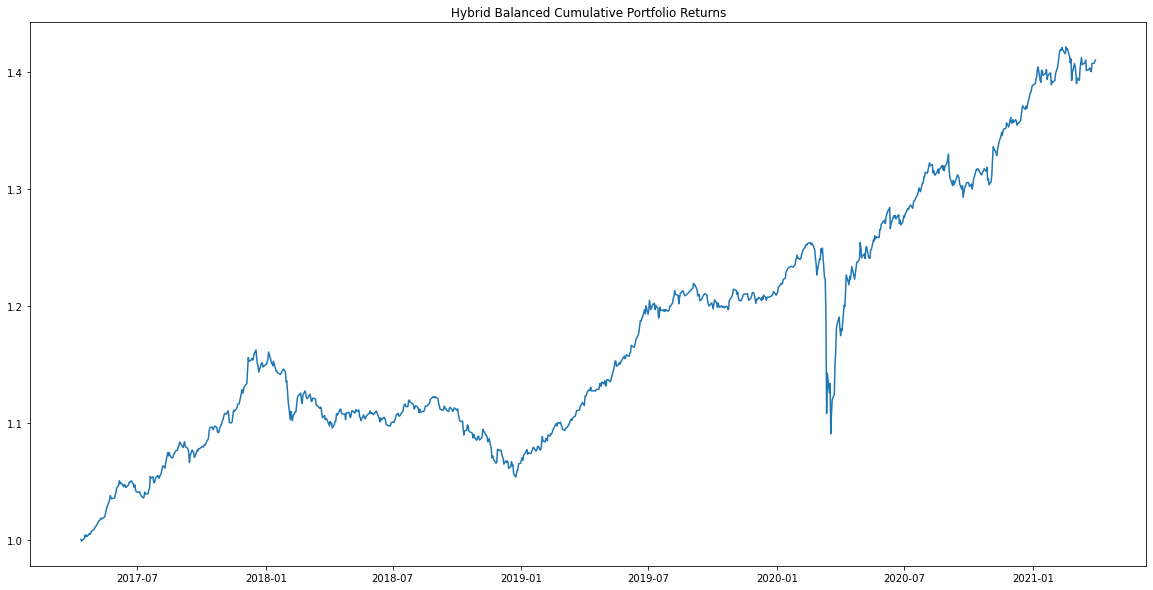

In [611]:
#Calculate and plot Hybrid Balanced Portfolio returns
hb_cumulative_returns = (1 + hb_weighted).cumprod()
hb_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Balanced Cumulative Portfolio Returns")

In [612]:
#Combined Traditional and Hybrid Balanced Dataframes
thb_cumulative_returns = pd.concat([tb_cumulative_returns, hb_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
thb_cumulative_returns.columns = columns
thb_cumulative_returns.head()

,Traditional Balanced,Hybrid Balanced
2017-04-12,0.999059,1.000687
2017-04-13,0.996306,0.999264
2017-04-17,1.000655,1.001747
2017-04-18,1.000869,1.004377
2017-04-19,0.999364,1.003004


<AxesSubplot:title={'center':'Traditional vs. Hybrid Balanced Portfolio Cumulative Returns'}>

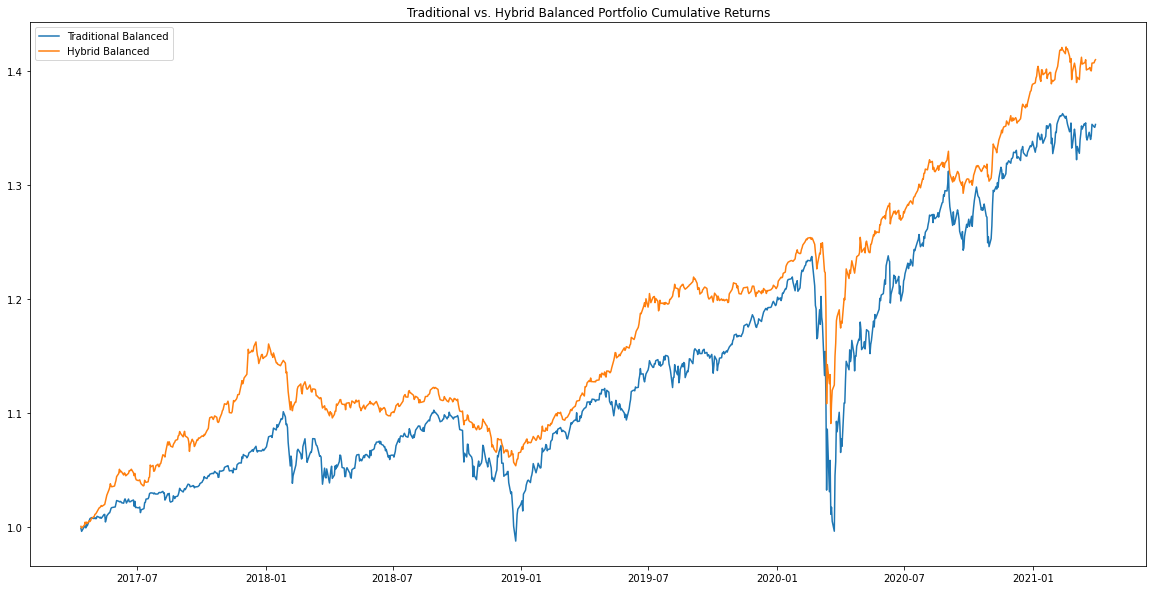

In [613]:
#Plot combined Balanced Dataframes
thb_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Balanced Portfolio Cumulative Returns")

### Need to update Sharpe Ratios for Balanced Portfolio

In [614]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thb_returns = pd.concat([tb_weighted, hb_weighted], axis="columns", join="inner")
columns = ["Traditional Balanced", "Hybrid Balanced"]
thb_returns.columns = columns
thb_returns.head()

,Traditional Balanced,Hybrid Balanced
2017-04-12,-0.000941,0.000687
2017-04-13,-0.002756,-0.001422
2017-04-17,0.004365,0.002485
2017-04-18,0.000214,0.002625
2017-04-19,-0.001503,-0.001367


In [615]:
#Calculate Sharpe Ratios on Traditional and Hybrid Balanced Portfolios
balanced_sharpe_ratios = ((thb_returns.mean()) * 252) / (thb_returns.std() * np.sqrt(252))
balanced_sharpe_ratios

Traditional Balanced    0.761784
Hybrid Balanced         1.277886
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

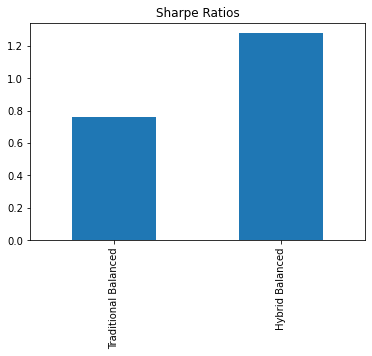

In [616]:
balanced_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

### Need to add summary statements

### Growth Section Below

In [617]:
#Assigning weights to Traditional Growth (tg) portfolio
tg_schz_percent = 0.8
tg_spy_percent = 0.2

weights_tg = [tg_schz_percent, tg_spy_percent]
tg_weighted = traditional_returns.dot(weights_tg)
tg_weighted.head()

2017-04-12    0.000894
2017-04-13   -0.000411
2017-04-17    0.001746
2017-04-18    0.002158
2017-04-19   -0.001404
dtype: float64

<AxesSubplot:title={'center':'Traditional Growth Portfolio Cumulative Returns'}>

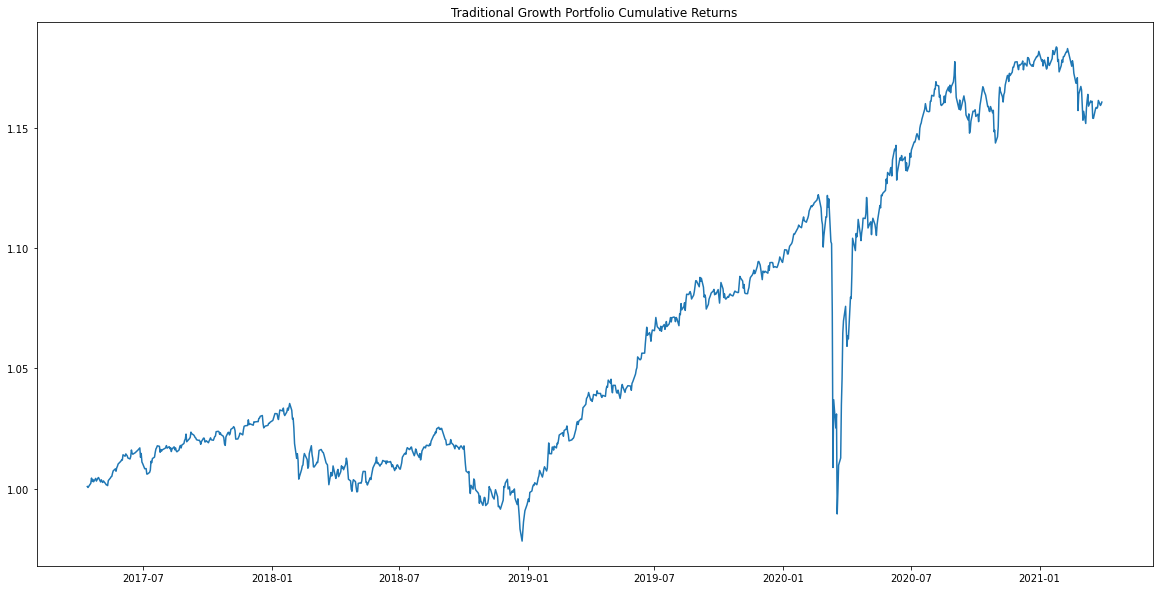

In [618]:
#Calculate and plot combined returns
tg_cumulative_returns = (1 + tg_weighted).cumprod()
tg_cumulative_returns.plot(figsize=(20,10), title = "Traditional Growth Portfolio Cumulative Returns")

In [619]:
# Adding 6% of Crypto (BTC) by reducing Bonds and Stocks proportionally
hg_btc_percent = 0.06
hg_schz_percent = tg_schz_percent - (tg_schz_percent * hg_btc_percent)
hg_spy_percent = tg_spy_percent - (tg_spy_percent * hg_btc_percent)


#Assigning weights to Hybrid Growth (hg) Portfolio
weights_hg = [hg_schz_percent, hg_spy_percent, hg_btc_percent]
hg_weighted = hybrid_returns.dot(weights_hg)
hg_weighted.head()

2017-04-12    0.000610
2017-04-13   -0.001940
2017-04-17    0.002905
2017-04-18    0.002921
2017-04-19   -0.001389
dtype: float64

<AxesSubplot:title={'center':'Hybrid Growth Portfolio Cumulative Returns'}>

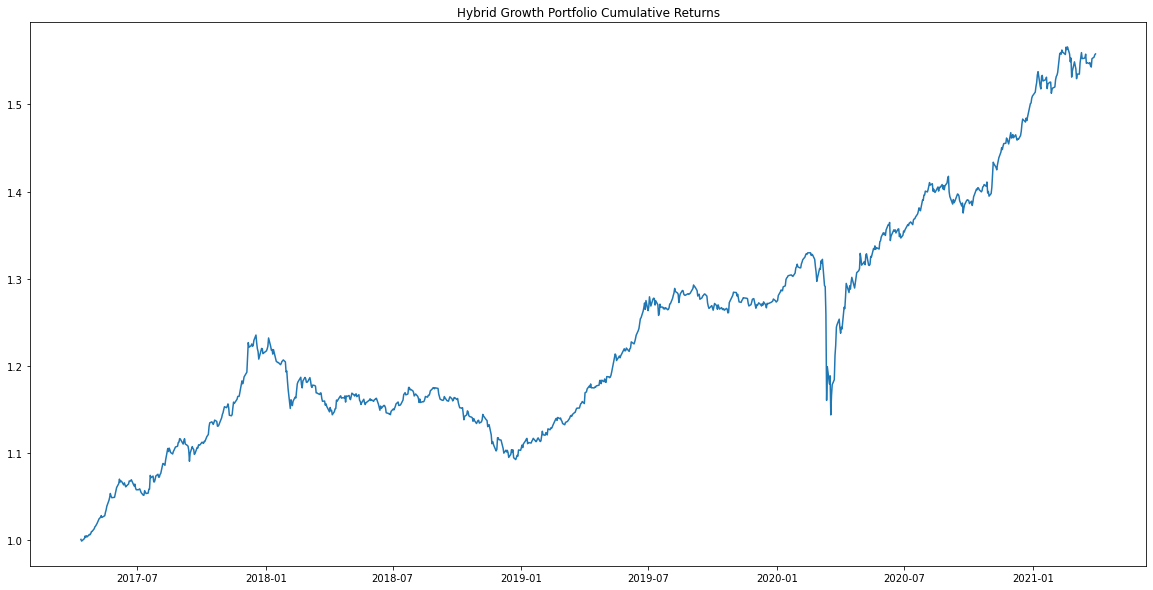

In [620]:
#Calculate and plot Hybrid Growth Portfolio returns
hg_cumulative_returns = (1 + hg_weighted).cumprod()
hg_cumulative_returns.plot(figsize=(20,10), title = "Hybrid Growth Portfolio Cumulative Returns")

In [627]:
#Combined Traditional Income and Hybrid Income dataframes
thg_cumulative_returns = pd.concat([tg_cumulative_returns, hg_cumulative_returns], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_cumulative_returns.columns = columns
thg_cumulative_returns.head()

,Traditional Growth,Hybrid Growth
2017-04-12,1.000894,1.000610
2017-04-13,1.000483,0.998669
2017-04-17,1.002230,1.001570
2017-04-18,1.004393,1.004495
2017-04-19,1.002982,1.003101


<AxesSubplot:title={'center':'Traditional vs. Hybrid Growth Portfolio Cumulative Returns'}>

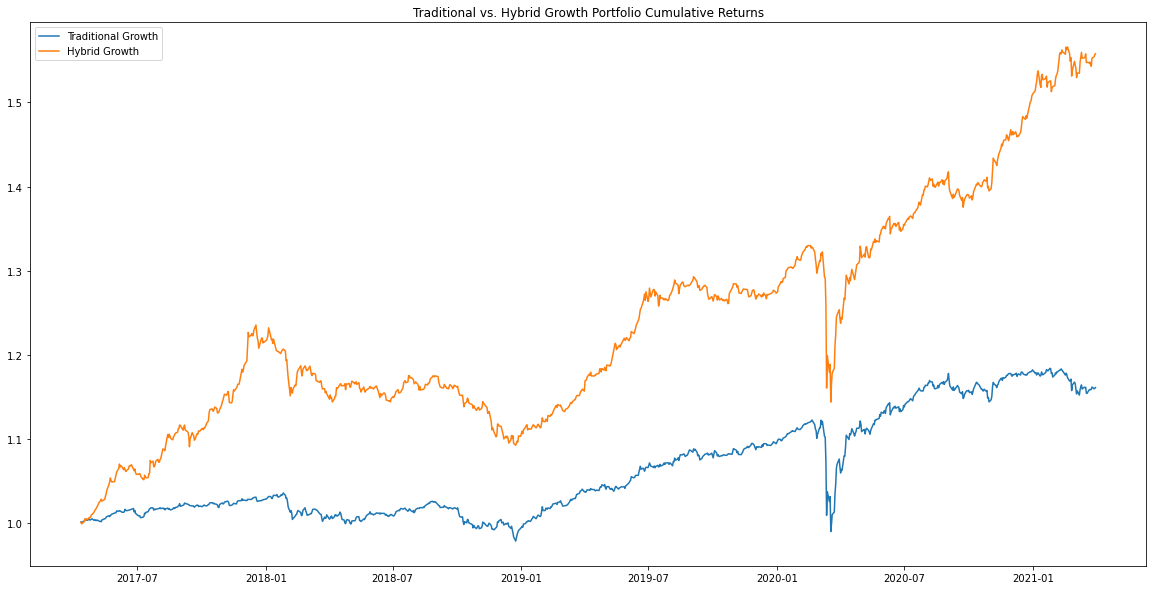

In [622]:
#Plot combined Income Dataframes
thg_cumulative_returns.plot(figsize=(20,10), title = "Traditional vs. Hybrid Growth Portfolio Cumulative Returns")

In [623]:
#Combine Traditional and Hybrid Income Weighted Daily Returns Dataframes
thg_returns = pd.concat([tg_weighted, hg_weighted], axis="columns", join="inner")
columns = ["Traditional Growth", "Hybrid Growth"]
thg_returns.columns = columns
thg_returns.head()

,Traditional Growth,Hybrid Growth
2017-04-12,0.000894,0.000610
2017-04-13,-0.000411,-0.001940
2017-04-17,0.001746,0.002905
2017-04-18,0.002158,0.002921
2017-04-19,-0.001404,-0.001389


In [624]:
#Calculate Sharpe Ratios on Traditional and Hybrid Income Portfolios
thg_sharpe_ratios = ((thg_returns.mean()) * 252) / (thg_returns.std() * np.sqrt(252))
thg_sharpe_ratios

Traditional Growth    0.665134
Hybrid Growth         1.428019
dtype: float64

<AxesSubplot:title={'center':'Sharpe Ratios'}>

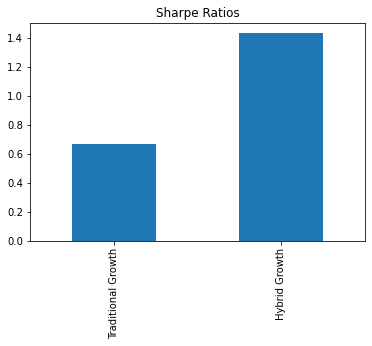

In [625]:
# Visualize the sharpe ratios as a bar plot
thg_sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Need to add summary statements